In [19]:
import pandas as pd
pd.set_option('display.max_rows', 999)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# **Exploratory Data Analysis**

In [261]:
# read in data
covid_f_raw = pd.read_csv('data/covid_forecast_2020-12-03.csv')
covid_h_raw = pd.read_csv('data/COVID_historical_us-counties.csv',
                         converters={'fips': lambda x: str(x)})

In [262]:
census_raw = pd.read_csv('data/2010_census_pop.csv',
                    converters={'Zip Code ZCTA': lambda x: str(x)})
pop_den_raw = pd.read_csv('data/uszips_pop_density.csv',
                     converters={'zip': lambda x: str(x)})
fips_pop = pd.read_csv('data/fips_population.csv',
                      converters={'FIPS': lambda x: str(x)})

In [263]:
fb = pd.read_table('data/county_county_aug2020.tsv', 
                   converters={'user_loc': lambda x: str(x), 
                               'fr_loc': lambda x: str(x)})

In [264]:
zips_fips_raw = pd.read_csv('data/zips_fips.csv',
                           converters={'ZIP': lambda x: str(x),
                                      'STCOUNTYFP': lambda x: str(x)})

**Areas of interest**

```
Challenges:
1) large dataset
- use random samples or duplicates?
2) dispersion of data -> challenging to work with
- use log transformation?

Notes
- how to treat counties?  Have to treat them in pairs or singularly?
- some counties are dropped because of low fb users
- SCI formula
- upscaling/downscaling from fips pop to zip pop to derive cases/zip

How to wrangle data:
1) Take random sample from population ~ 1 million rows
2) Remove duplicates ~ 5 million rows

Data Cleaning
1) add zeros to four digit zip codes - won't do
2) add population data by zip code - done
3) normalize cases/per capita - not started
4) dataset of cities and zip code - not started
5) added log transformation field - done

Views of Analysis:
- two buckets - high/low - won't do
- stratified buckets - 5 or more? 

EDA - questions to answer
The Basics
- Are zip links directional? - done
- What are the highest/smallest SCI indices, by zip? - done
    -> create histogram of distribution of SCI indices - done
- distribution of SCI indices? - done 
- What's the range of SCI indices? - done
- How many zip pairs are there? - done
- Average scaled_sci per zip? Zips with highest, lowest scaled_sci? - done, won't do
- view of zip and average SCI - done

How does the SCI relate to population? Do we see higher SCIs in zips with greater populations?
1a) SCI vs population, all zips - DONE
scatterplot of zip codes with dependent variable as SCI, independent variable as pop
1b) SCI vs population/sq kilometer - DONE
2) SCI vs population, grouped zips by population buckets
- What range does SCI take over various population buckets?

Additional Data Cleaning
- mapping of FIPs to ZIPs
- conversion of FIPs and ZIPs to dtype object vs int

Overall Trends - COVID vs SCI
1) SCI vs total COVID cases - DONE
2) SCI vs total COVID deaths - DONE

Historical spread of COVID, relationship to SCI - timeseries
1) How does the historical spread rate of COVID differ between counties with high SCI scores and those with low SCI scores?

Future spread of COVID, relationship to SCI
- Do prediction models indicate counties with higher SCIs will get more cases?

Can I provide a recommendation to public health experts on potential areas of spread?

Hypothesis testing
- Is the incidence of COVID between zip pairs with high SCI significantly different than the incidence of COVID between zip pairs with low SCI?

Questions
- How am I defining the incidence of COVID? Spread? total number of cases? growth rate over time?
- Recommendations/audience definition

Extra Credit
Network graph approach 
- how should network analysis be used as a tool to fight disease spread?
1) Which nodes (zip codes) have the highest number of connections to other nodes (zip codes)? 
1a) Which nodes w/highest covid spread have highest number of connections to other high disease nodes? 
* edges would be scaled for a minimum SCI
* degree centrality

GIS graphs
- sample two counties - show maps of SCI

Story:
How does a ZIP's SCI impact itself?
0) What SCI is
1) Distribution of SCI
- average
2) SCI vs Population
- examples
3) SCI vs COVID
- muted trends
- maybe covid is too widespread to notice any significant differences?
4) SCI vs COVID timeseries

How does a ZIP's SCI impact other ZIPs?



data sources:
covid_forecast_2020-12-03.csv - nytimes
COVID_historical_us-counties.csv - nytimes
fb_SCI_county_county_aug2020.tsv - facebook data for good
2010_census_pop.csv - US Census Bureau 
uszips_pop_density.csv - https://simplemaps.com/data/us-zips
zip-county-fips - https://www.kaggle.com/danofer/zipcodes-county-fips-crosswalk
2019 census estimate - https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/

c_historical = pd.read_csv('data/COVID_historical_us-counties.csv')
fb_sci = pd.read_csv('data/fb_SCI_county_county_aug2020.tsv', sep='\t')
census = pd.read_csv('data/2010_census_pop.csv')
pop_den = uszips_pop_density.csv
zip_fips = zips_fips.csv
```


## Data Cleaning

In [270]:
# create 
fb['log_sci'] = np.log10(fb['scaled_sci'])

In [675]:
# create population density table
pop_den = pop_den_raw[['zip', 'density']]
pop_den

zip  density
0      00601    111.4
1      00602    523.5
2      00603    667.9
3      00606     60.4
4      00610    312.0
...      ...      ...
33092  99923      2.1
33093  99925      5.7
33094  99926      4.2
33095  99927      0.2
33096  99929      0.4

[33097 rows x 2 columns]

In [676]:
pop_den

zip  density
0      00601    111.4
1      00602    523.5
2      00603    667.9
3      00606     60.4
4      00610    312.0
...      ...      ...
33092  99923      2.1
33093  99925      5.7
33094  99926      4.2
33095  99927      0.2
33096  99929      0.4

[33097 rows x 2 columns]

## EDA - questions to answer

### The Basics

**Are zip links directional?**

In [424]:
fb['scaled_sci']

0           13971142
1             145133
2             200193
3             371688
4              95859
              ...   
10426436       13881
10426437        8328
10426438    11155562
10426439    14004203
10426440    37515311
Name: scaled_sci, Length: 10426441, dtype: int64

**What are the min and max SCIs?**

In [425]:
fb['scaled_sci'].describe().astype(int)

count      10426441
mean          46074
std         2179666
min               1
25%            1081
50%            1942
75%            4036
max      1000000000
Name: scaled_sci, dtype: int64

**What is the distribution of SCI indices?**

In [426]:
fb.median()

user_loc      30035.000000
fr_loc        30035.000000
scaled_sci     1942.000000
log_sci           3.288249
dtype: float64

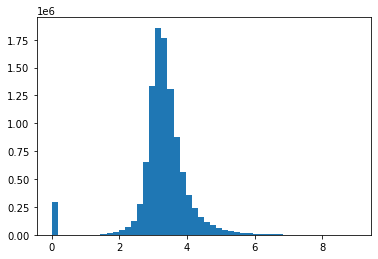

In [432]:
plt.hist(fb['log_sci'], bins=50);

In [458]:
log_sci_hist = fb['log_sci']

In [460]:
log_sci_hist = log_sci_hist.where(log_sci_hist > 0)

In [461]:
log_sci_hist

0           7.145232
1           5.161766
2           5.301449
3           5.570179
4           4.981633
              ...   
10426436    4.142421
10426437    3.920541
10426438    7.047491
10426439    7.146258
10426440    7.574209
Name: log_sci, Length: 10426441, dtype: float64

''

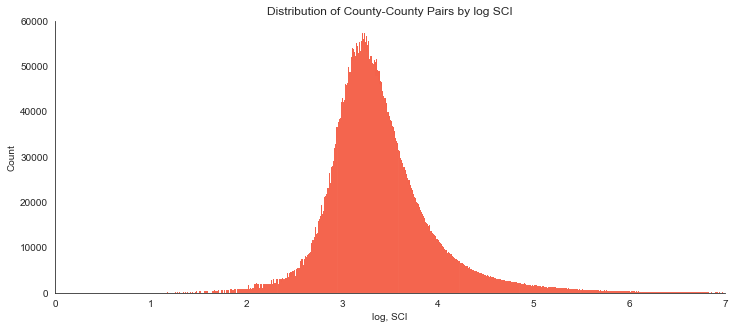

In [493]:
f, ax = plt.subplots(figsize=(12, 5))
sns.despine(f)

sns.histplot(log_sci_hist, 
             color='#F12101'
            )

sns.set_style("white")

ax.set_ylim(0, 60000)
ax.set_xlim(0, 7)
ax.set_xlabel('log, SCI')
ax.set_title('Distribution of County-County Pairs by log SCI')
;



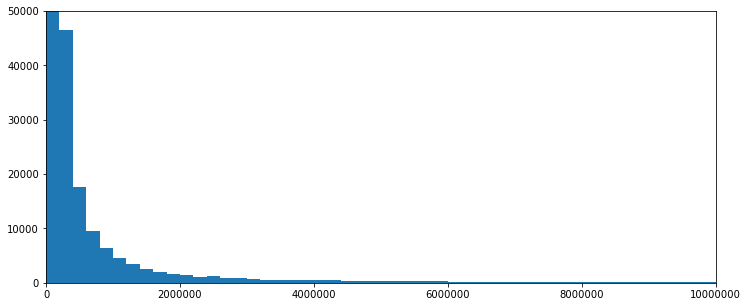

In [681]:
fig, ax = plt.subplots(figsize=(12, 5))
counts, bins, patches = ax.hist(fb['scaled_sci'], bins=5000)
ax.set_ylim(0, 50000)
ax.set_xlim(0, 10000000)
ax.ticklabel_format(useOffset=False, style='plain')

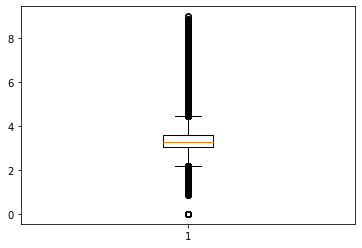

In [682]:
plt.boxplot(fb['log_sci'])
ax.ticklabel_format(useOffset=False, style='plain');

**Average scaled_sci per zip?**

In [683]:
fb.columns

Index(['user_loc', 'fr_loc', 'scaled_sci', 'log_sci'], dtype='object')

In [684]:
fb.groupby(by='user_loc').sum('scaled_sci').astype(int).sort_values(by='log_sci')

scaled_sci  log_sci
user_loc                     
60020      606989480     2250
69100      506414831     3551
69120      422975097     4891
72093      406876391     5718
72095      275029813     6020
...              ...      ...
37133       37086591    12432
38053      161550822    12460
29169       53971024    12493
20061       62380441    12591
13053       66233422    12800

[3229 rows x 2 columns]

In [685]:
fb.sort_values(by='scaled_sci')

user_loc fr_loc  scaled_sci   log_sci
568263     05129  72079           1  0.000000
5483041    31091  06027           1  0.000000
6486550    38039  48393           1  0.000000
6486549    38039  48391           1  0.000000
4328891    27055  38085           1  0.000000
...          ...    ...         ...       ...
8197740    48033  48033   684633720  8.835458
7722930    46063  46063   757162537  8.879189
5332730    30109  30109   789302096  8.897243
303620     02282  02282   899409678  8.953958
5209990    30033  30033  1000000000  9.000000

[10426441 rows x 4 columns]

### How does the SCI relate to population?

#### SCI vs Population

In [686]:
census_raw

Zip Code ZCTA  2010 Census Population
0             01001                   16769
1             01002                   29049
2             01003                   10372
3             01005                    5079
4             01007                   14649
...             ...                     ...
33087         99923                      87
33088         99925                     819
33089         99926                    1460
33090         99927                      94
33091         99929                    2338

[33092 rows x 2 columns]

In [687]:
census_join = census_raw.set_index('Zip Code ZCTA').join(fb.set_index('user_loc'))
cen_re = census_join.reset_index().dropna(axis=0).drop(columns='fr_loc').groupby(by='index').mean('scaled_sci')
cen_re.rename(columns={'index':'user_zip', '2010 Census Population': 'pop'}, inplace=True)

In [688]:
cen_re.reset_index()

index      pop    scaled_sci   log_sci
0     01001  16769.0  18051.920718  3.447295
1     01003  10372.0  10736.893465  3.591924
2     01005   5079.0  69717.397027  3.284667
3     01007  14649.0  36740.415609  3.277721
4     01009    741.0  13407.449675  3.320542
...     ...      ...           ...       ...
1486  72141    625.0  37517.751936  2.324113
1487  72143  35169.0  27528.043667  2.530625
1488  72149      0.0  48107.852896  2.163793
1489  72153   2572.0  39053.460824  2.377968
1490  78010   3386.0  24755.935893  3.346751

[1491 rows x 4 columns]

In [689]:
x = cen_re['pop']
y = cen_re['scaled_sci']

Text(0.5, 1.0, 'Mean SCI vs. Population')

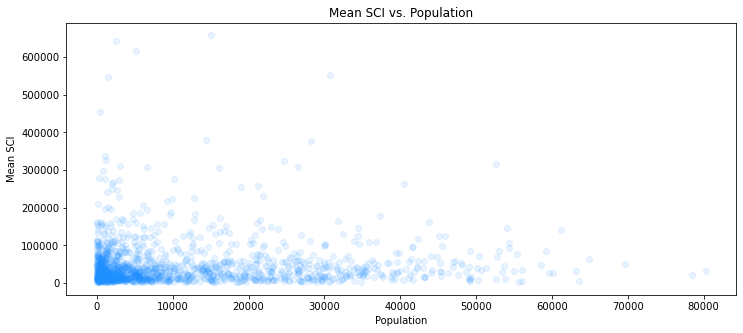

In [690]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.scatter(x, y, alpha=.1, color='dodgerblue')
ax.set_ylabel('Mean SCI')
ax.set_xlabel('Population')
ax.set_title('Mean SCI vs. Population')

#### SCI vs Population, log transformation

In [691]:
cen_re['log_sci'] = np.log10(cen_re['scaled_sci'])

In [692]:
x = cen_re['pop']
y = cen_re['log_sci']

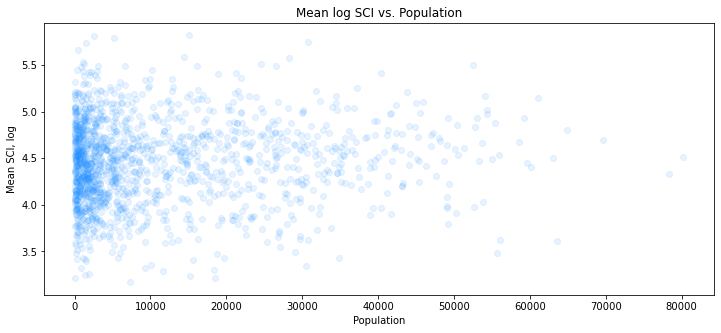

In [693]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.scatter(x, y, alpha=.1, color='dodgerblue')
ax.set_ylabel('Mean SCI, log')
ax.set_xlabel('Population')
ax.set_title('Mean log SCI vs. Population');

#### SCI (log transformation) vs Population/sq km

In [694]:
popdensci = cen_re.join(pop_den.set_index('zip'))

''

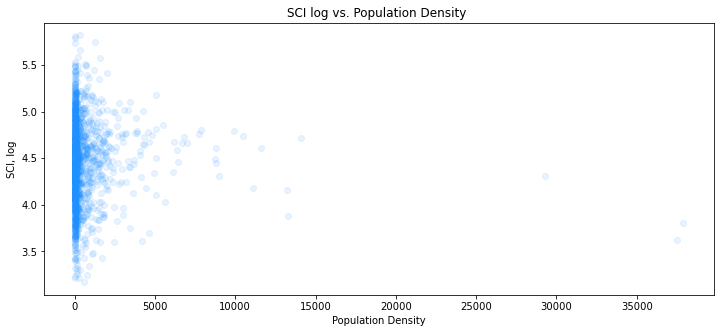

In [695]:
x = popdensci['density']
y = popdensci['log_sci']

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.scatter(x, y, alpha=.1, color='dodgerblue')
ax.set_ylabel('SCI, log')
ax.set_xlabel('Population Density')
ax.set_title('SCI log vs. Population Density ')
;

### SCI vs total COVID cases

#### Data Cleaning

In [696]:
# grouping covid cases by fips
covid_h = covid_h_raw.groupby('fips').max()
# tables used below:
## popdensci, zips_fips_raw, covid_h

In [697]:
covid_h

date      county           state   cases   deaths
fips                                                          
       2020-12-04     Unknown         Wyoming  329406  24323.0
01001  2020-12-04     Autauga         Alabama    2945     42.0
01003  2020-12-04     Baldwin         Alabama    9501    138.0
01005  2020-12-04     Barbour         Alabama    1217     29.0
01007  2020-12-04        Bibb         Alabama    1270     38.0
...           ...         ...             ...     ...      ...
72151  2020-12-04     Yabucoa     Puerto Rico     600      NaN
72153  2020-12-04       Yauco     Puerto Rico     749      NaN
78010  2020-12-04   St. Croix  Virgin Islands     609      7.0
78020  2020-12-04    St. John  Virgin Islands     106      1.0
78030  2020-12-04  St. Thomas  Virgin Islands     898     15.0

[3218 rows x 5 columns]

In [698]:
popdensci_join

fips   zips      pop    scaled_sci   log_sci  density       COUNTYNAME  \
0     01001  36067  26954.0   5277.014246  3.722388     43.5   Autauga County   
1     01001  36003   1975.0  14718.700526  4.167869      8.2   Autauga County   
2     01001  36091   3648.0   6445.646330  3.809266     17.2   Autauga County   
3     01001  36051   2304.0  10743.957572  4.031164     17.5   Autauga County   
4     01005  36017   3318.0  12606.702694  4.100602     20.6   Barbour County   
...     ...    ...      ...           ...       ...      ...              ...   
2231  55133  53045  21686.0   7415.146795  3.870120    582.4  Waukesha County   
2232  55133  53007   1841.0   8779.978012  3.943493    920.2  Waukesha County   
2233  55133  53017   5538.0   8285.122639  3.918299    122.2  Waukesha County   
2234  55133  53029  20799.0   6907.350263  3.839311    215.9  Waukesha County   
2235  55133  53069    697.0  36255.694333  4.559376    696.7  Waukesha County   

     STATE CLASSFP        date    county      state    cases  deaths  \
0       AL      H1  2020-12-04   Autauga    Alabama   2945.0    42.0   
1       AL      H1  2020-12-04   Autauga    Alabama   2945.0    42.0   
2       AL      H1  2020-12-04   Autauga    Alabama   2945.0    42.0   
3       AL      H1  2020-12-04   Autauga    Alabama   2945.0    42.0   
4       AL      H1  2020-12-04   Barbour    Alabama   1217.0    29.0   
...    ...     ...         ...       ...        ...      ...     ...   
2231    WI      H1  2020-12-04  Waukesha  Wisconsin  29812.0   233.0   
2232    WI      H1  2020-12-04  Waukesha  Wisconsin  29812.0   233.0   
2233    WI      H1  2020-12-04  Waukesha  Wisconsin  29812.0   233.0   
2234    WI      H1  2020-12-04  Waukesha  Wisconsin  29812.0   233.0   
2235    WI      H1  2020-12-04  Waukesha  Wisconsin  29812.0   233.0   

       fip_pop  zip_pop_percent  cases_per_zip  deaths_per_zip  \
0      34881.0         0.772742    2275.724033       32.455148   
1      34881.0         0.056621     166.749090        2.378085   
2      34881.0         0.104584     308.000344        4.392535   
3      34881.0         0.066053     194.526533        2.774232   
4      21546.0         0.153996     187.413255        4.465887   
...        ...              ...            ...             ...   
2231  105637.0         0.205288    6120.043470       47.832085   
2232  105637.0         0.017428     519.551786        4.060632   
2233  105637.0         0.052425    1562.888533       12.214981   
2234  105637.0         0.196891    5869.721669       45.875659   
2235  105637.0         0.006598     196.701572        1.537350   

      cases_per_capita  
0            54.183906  
1             3.970216  
2             7.333342  
3             4.631584  
4             6.462526  
...                ...  
2231         26.266281  
2232          2.229836  
2233          6.707676  
2234         25.191938  
2235          0.844213  

[2236 rows x 19 columns]

In [699]:
covid_h = covid_h.reset_index()

In [700]:
covid_h['fips'].replace('', np.nan, inplace=True)
covid_h = covid_h.dropna()
popdensci_join = popdensci.join(zips_fips_raw.set_index('ZIP')).reset_index().sort_values('STCOUNTYFP')
popdensci_join = popdensci_join.dropna()
popdensci_join = popdensci_join.rename(columns={'index':'zips', 'STCOUNTYFP':'fips'})
popdensci_join = popdensci_join.set_index('fips')
popdensci_join = popdensci_join.join(covid_h.set_index('fips'))

In [701]:
popdensci_join = popdensci_join.reset_index()

In [702]:
# upscaling/downscaling data
popdensci_join['fip_pop'] = popdensci_join['pop'].groupby(popdensci_join['fips']).transform('sum')
popdensci_join['zip_pop_percent'] = popdensci_join['pop']/popdensci_join['fip_pop']
popdensci_join['cases_per_zip'] = popdensci_join['zip_pop_percent'] * popdensci_join['cases']
popdensci_join['deaths_per_zip'] = popdensci_join['zip_pop_percent'] * popdensci_join['deaths']
popdensci_join['cases_per_capita'] = popdensci_join['cases_per_zip'] / popdensci_join['deaths']


''

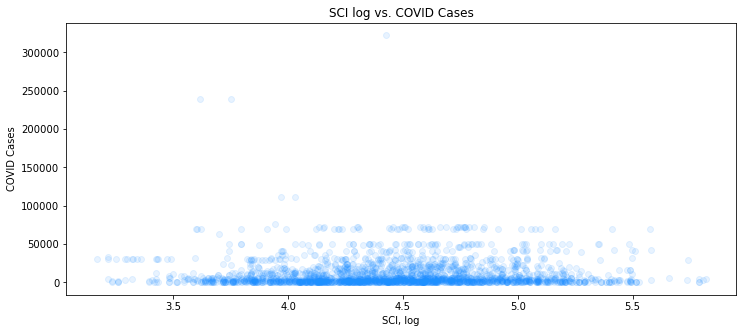

In [703]:
x = popdensci_join['log_sci']
y = popdensci_join['cases']


fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.scatter(x, y, alpha=.1, color='dodgerblue')
ax.set_xlabel('SCI, log')
ax.set_ylabel('COVID Cases')
ax.set_title('SCI log vs. COVID Cases')
# ax.set_ylim(0, 25)
;

''

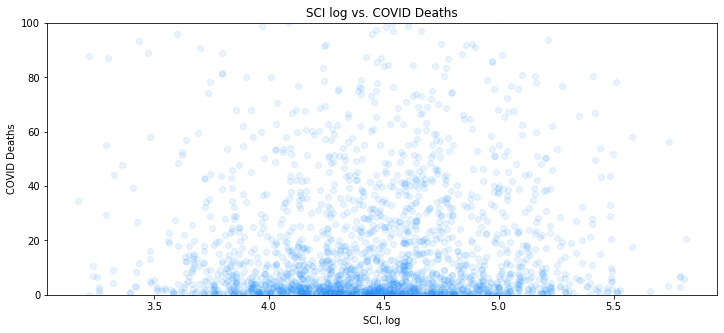

In [704]:
x = popdensci_join['log_sci']
y = popdensci_join['deaths_per_zip']


fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.scatter(x, y, alpha=.1, color='dodgerblue')
ax.set_xlabel('SCI, log')
ax.set_ylabel('COVID Deaths')
ax.set_title('SCI log vs. COVID Deaths')
ax.set_ylim(0, 100)
;

''

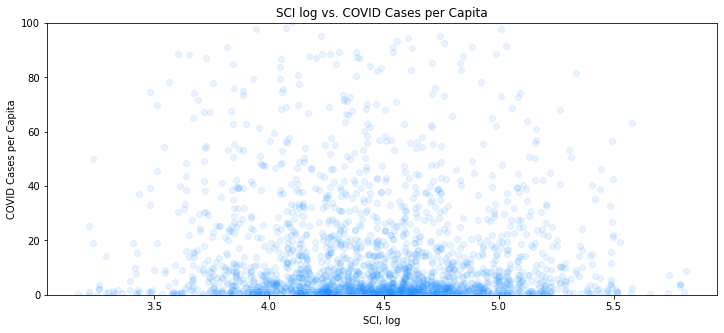

In [705]:
x = popdensci_join['log_sci']
y = popdensci_join['cases_per_capita']


fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.scatter(x, y, alpha=.1, color='dodgerblue')
ax.set_xlabel('SCI, log')
ax.set_ylabel('COVID Cases per Capita')
ax.set_title('SCI log vs. COVID Cases per Capita')
ax.set_ylim(0, 100)
;

### SCI vs COVID cases, timeseries

#### Data Cleaning

In [265]:
# copy cen_re into new df
# create SCI quantile groups
cen_re_timeseries = cen_re.copy()
cen_re_timeseries.loc[cen_re_timeseries['log_sci'] <= cen_re_timeseries['log_sci'].quantile(.25), 'SCI_lower_25'] = '1'
cen_re_timeseries.loc[cen_re_timeseries['log_sci'] >= cen_re_timeseries['log_sci'].quantile(.75), 'SCI_upper_25'] = '1'
cen_re_timeseries.loc[(cen_re_timeseries['log_sci'] > cen_re_timeseries['log_sci'].quantile(.25)) & \
           (cen_re_timeseries['log_sci'] < cen_re_timeseries['log_sci'].quantile(.75)) , \
           'SCI_middle_50'] = '1'

# join cen_re_timeseries to zips/fips mapping and covid_h_raw
cen_re_timeseries = cen_re_timeseries.reset_index().rename(columns={'index':'zip'})
cen_re_timeseries = cen_re_timeseries.set_index('zip').join(zips_fips_raw.set_index('ZIP')).reset_index().rename(columns={'index':'zip'})
cen_re_timeseries = cen_re_timeseries.set_index('STCOUNTYFP').join(covid_h_raw.set_index('fips'))

NameError: name 'cen_re' is not defined

In [998]:
# cen_re_timeseries = cen_re_timeseries.drop(columns=['pop', 'CLASSFP'])

In [999]:
cen_re_timeseries

zip     pop    scaled_sci   log_sci SCI_lower_25 SCI_upper_25  \
01001  36003  1975.0  14718.700526  4.167869          NaN          NaN   
01001  36003  1975.0  14718.700526  4.167869          NaN          NaN   
01001  36003  1975.0  14718.700526  4.167869          NaN          NaN   
01001  36003  1975.0  14718.700526  4.167869          NaN          NaN   
01001  36003  1975.0  14718.700526  4.167869          NaN          NaN   
...      ...     ...           ...       ...          ...          ...   
55133  53069   697.0  36255.694333  4.559376          NaN          NaN   
55133  53069   697.0  36255.694333  4.559376          NaN          NaN   
55133  53069   697.0  36255.694333  4.559376          NaN          NaN   
NaN    01097   111.0  10636.227005  4.026788            1          NaN   
NaN    48397     0.0   8556.072778  3.932274            1          NaN   

      SCI_middle_50       COUNTYNAME STATE CLASSFP        date    county  \
01001             1   Autauga County    AL      H1  2020-03-24   Autauga   
01001             1   Autauga County    AL      H1  2020-03-25   Autauga   
01001             1   Autauga County    AL      H1  2020-03-26   Autauga   
01001             1   Autauga County    AL      H1  2020-03-27   Autauga   
01001             1   Autauga County    AL      H1  2020-03-28   Autauga   
...             ...              ...   ...     ...         ...       ...   
55133             1  Waukesha County    WI      H1  2020-12-02  Waukesha   
55133             1  Waukesha County    WI      H1  2020-12-03  Waukesha   
55133             1  Waukesha County    WI      H1  2020-12-04  Waukesha   
NaN             NaN              NaN   NaN     NaN         NaN       NaN   
NaN             NaN              NaN   NaN     NaN         NaN       NaN   

           state    cases  deaths  
01001    Alabama      1.0     0.0  
01001    Alabama      4.0     0.0  
01001    Alabama      6.0     0.0  
01001    Alabama      6.0     0.0  
01001    Alabama      6.0     0.0  
...          ...      ...     ...  
55133  Wisconsin  29119.0   221.0  
55133  Wisconsin  29460.0   226.0  
55133  Wisconsin  29812.0   233.0  
NaN          NaN      NaN     NaN  
NaN          NaN      NaN     NaN  

[580560 rows x 15 columns]

In [259]:
middle_50 = cen_re_timeseries.loc[cen_re_timeseries['SCI_middle_50'] == '1'].groupby(['date']).mean('cases')
middle_50 = middle_50.drop(columns=['scaled_sci', 'log_sci', 'deaths', 'pop']).rename(columns={'cases':'middle_50'})

lower_25 = cen_re_timeseries.loc[cen_re_timeseries['SCI_lower_25'] == '1'].groupby('date').mean('cases')
lower_25 = lower_25.drop(columns=['scaled_sci', 'log_sci', 'deaths', 'pop']).rename(columns={'cases':'lower_25'})

upper_25 = cen_re_timeseries.loc[cen_re_timeseries['SCI_upper_25'] == '1'].groupby('date').mean('cases')
upper_25 = upper_25.drop(columns=['scaled_sci', 'log_sci', 'deaths', 'pop']).rename(columns={'cases':'upper_25'})

quadrants = pd.concat([lower_25, middle_50, upper_25], axis=1)

quadrants = quadrants.sort_index()


NameError: name 'cen_re_timeseries' is not defined

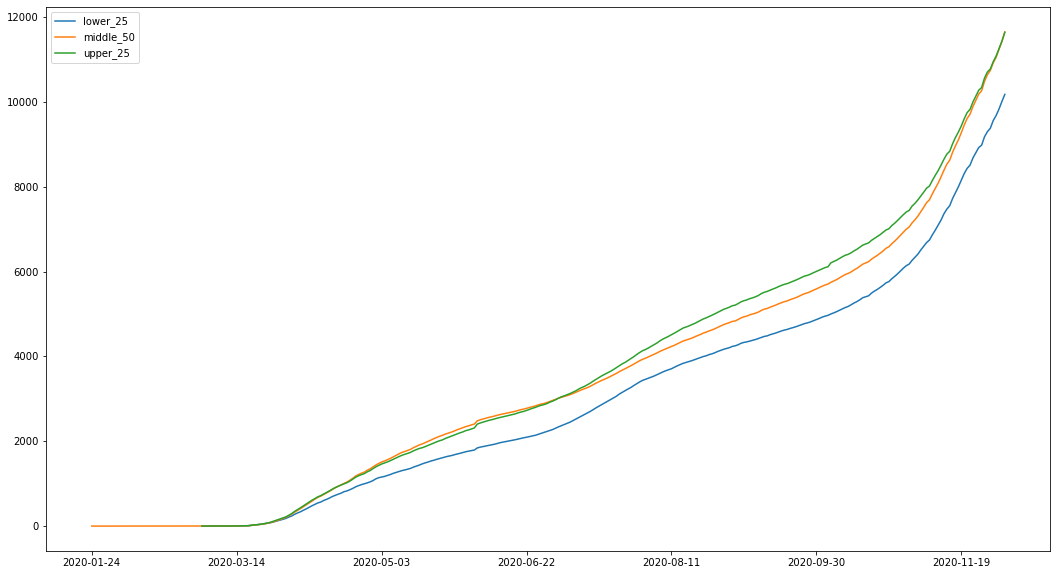

In [710]:
quadrants.plot.line(figsize=(18,10));

__________________________________

# Graph Analysis

## Data Cleaning

In [ ]:
'''
0) data clean - get a clean list of fips <-> population, pop density, cases, cases/capita - DONE
1a) Intro - what is a node vs edge
1b) Describe node sizing, edge sizing
1c) Example: San Francisco connections to other zips vs rural county to other zips -> population density as a node attributes
EDIT: change san francisco and Kern county example to only include counties w/SCI greater than a certain threshold
2) Bucket by SCI quadrant -> lower 25%, middle 50%, upper 25%
- create quadrants in fb - done
- create new fb_ dataframes - done
- random sample new fb_ dataframes - done
- plot new fb_ dataframes - done
- calculate stats for each quadrant -> covid cases, connectedness, degree

3) Hypothesis testing - test the idea that higher SCIs are more connected and have higher rates of covid spread

4) Quantitative measures - shortest path, connectedness, eigenvector
'''

In [272]:
# na_covid_cases
# na_fips_pop_covid # final table of fips <> pop <> cases <> cases_per_capita <> deaths
# sf_county # sf county to fips SCI
# kern_county # kern county to fips SCI
# fb_ga_lower_25
# fb_ga_middle_50
# fb_ga_upper_25
fb_ga = fb.copy()

In [273]:
fb_ga

user_loc fr_loc  scaled_sci   log_sci
0           01001  01001    13971142  7.145232
1           01001  01003      145133  5.161766
2           01001  01005      200193  5.301449
3           01001  01007      371688  5.570179
4           01001  01009       95859  4.981633
...           ...    ...         ...       ...
10426436    78030  72151       13881  4.142421
10426437    78030  72153        8328  3.920541
10426438    78030  78010    11155562  7.047491
10426439    78030  78020    14004203  7.146258
10426440    78030  78030    37515311  7.574209

[10426441 rows x 4 columns]

In [274]:
# create fb_ga quartiles for lower middle, and upper quartiles
fb_ga.loc[fb_ga['log_sci'] <= fb_ga['log_sci'].quantile(.25), 'SCI_lower_25'] = '1'
fb_ga.loc[fb_ga['log_sci'] >= fb_ga['log_sci'].quantile(.75), 'SCI_upper_25'] = '1'
fb_ga.loc[(fb_ga['log_sci'] > fb_ga['log_sci'].quantile(.25)) & \
           (fb_ga['log_sci'] < fb_ga['log_sci'].quantile(.75)) , \
           'SCI_middle_50'] = '1'

fb_ga_lower_25 = fb_ga[fb_ga.SCI_lower_25 == '1']
fb_ga_middle_50 = fb_ga[fb_ga.SCI_middle_50 == '1']
fb_ga_upper_25 = fb_ga[fb_ga.SCI_upper_25 == '1']

In [275]:
fb_ga_lower_25

user_loc fr_loc  scaled_sci   log_sci SCI_lower_25 SCI_upper_25  \
73          01001  02070         643  2.808211            1          NaN   
76          01001  02105         608  2.783904            1          NaN   
81          01001  02158         570  2.755875            1          NaN   
93          01001  02275         865  2.937016            1          NaN   
99          01001  04007         994  2.997386            1          NaN   
...           ...    ...         ...       ...          ...          ...   
10426351    78030  56043         532  2.725912            1          NaN   
10426352    78030  56045         280  2.447158            1          NaN   
10426354    78030  60020           1  0.000000            1          NaN   
10426355    78030  60050         755  2.877947            1          NaN   
10426357    78030  69100         690  2.838849            1          NaN   

         SCI_middle_50  
73                 NaN  
76                 NaN  
81                 NaN  
93                 NaN  
99                 NaN  
...                ...  
10426351           NaN  
10426352           NaN  
10426354           NaN  
10426355           NaN  
10426357           NaN  

[2610088 rows x 7 columns]

In [276]:
# Cleaning COVID datasets
na_covid_cases = covid_h_raw.groupby('fips').max()
na_covid_cases.reset_index(inplace=True)
na_covid_cases.replace("", np.nan, inplace=True)
na_covid_cases.dropna(inplace=True)

In [277]:
na_fips_pop_covid = fips_pop.set_index('FIPS').join(na_covid_cases.set_index('fips')).dropna()

In [278]:
na_fips_pop_covid['cases_per_capita'] = na_fips_pop_covid['cases']/1000

In [279]:
na_fips_pop_covid.sort_values('cases_per_capita').reset_index()

FIPS State                   Area_Name   2010_pop        date  \
0     48301    TX               Loving County         82  2020-12-04   
1     48269    TX                 King County        286  2020-12-04   
2     02164    AK  Lake and Peninsula Borough      1,631  2020-12-04   
3     48033    TX               Borden County        641  2020-12-04   
4     35021    NM              Harding County        695  2020-12-04   
...     ...   ...                         ...        ...         ...   
3129  48201    TX               Harris County  4,092,459  2020-12-04   
3130  04013    AZ             Maricopa County  3,817,117  2020-12-04   
3131  12086    FL           Miami-Dade County  2,496,435  2020-12-04   
3132  17031    IL                 Cook County  5,194,675  2020-12-04   
3133  06037    CA          Los Angeles County  9,818,605  2020-12-04   

                          county       state     cases  deaths  \
0                         Loving       Texas       1.0     0.0   
1                           King       Texas       2.0     0.0   
2     Lake and Peninsula Borough      Alaska       5.0     0.0   
3                         Borden       Texas       5.0     0.0   
4                        Harding  New Mexico       6.0     0.0   
...                          ...         ...       ...     ...   
3129                      Harris       Texas  195558.0  3046.0   
3130                    Maricopa     Arizona  224924.0  4119.0   
3131                  Miami-Dade     Florida  238812.0  3888.0   
3132                        Cook    Illinois  322122.0  6852.0   
3133                 Los Angeles  California  430713.0  7842.0   

      cases_per_capita  
0                0.001  
1                0.002  
2                0.005  
3                0.005  
4                0.006  
...                ...  
3129           195.558  
3130           224.924  
3131           238.812  
3132           322.122  
3133           430.713  

[3134 rows x 10 columns]

## Intro - San Francisco, network

In [285]:
sf_county = fb[fb['user_loc'] == '06075']

In [286]:
sf_county

user_loc fr_loc  scaled_sci   log_sci
720067    06075  01001        1175  3.070038
720068    06075  01003        1690  3.227887
720069    06075  01005         664  2.822168
720070    06075  01007         529  2.723456
720071    06075  01009         540  2.732394
...         ...    ...         ...       ...
723291    06075  72151         351  2.545307
723292    06075  72153         432  2.635484
723293    06075  78010        2531  3.403292
723294    06075  78020        9224  3.964919
723295    06075  78030        3558  3.551206

[3229 rows x 4 columns]

In [287]:
g_sf = nx.from_pandas_edgelist(sf_county, "user_loc", "fr_loc", ["scaled_sci", "log_sci"])
print('# of edges: {}'.format(g_sf.number_of_edges()))
print('# of nodes: {}'.format(g_sf.number_of_nodes()))

# of edges: 3229
# of nodes: 3229


In [288]:
# reset index of na_fips_pop_covid
na_fips_pop_covid = na_fips_pop_covid.reset_index()

# create nodelist from popdensci_join
nodelist = na_fips_pop_covid.copy()
nodelist = nodelist[['FIPS', 'cases_per_capita']]

In [289]:
nodelist

FIPS  cases_per_capita
0     01001             2.945
1     01003             9.501
2     01005             1.217
3     01007             1.270
4     01009             3.231
...     ...               ...
3129  56037             2.077
3130  56039             1.724
3131  56041             1.175
3132  56043             0.517
3133  56045             0.419

[3134 rows x 2 columns]

In [290]:
# deduplicate nodelists by joining edgelist to it
# node_attributes = sf_county.join(nodelist)

In [291]:
# convert node attributes in nodelist to dict
node_attributes_sf = dict(zip(nodelist.FIPS, nodelist.cases_per_capita))

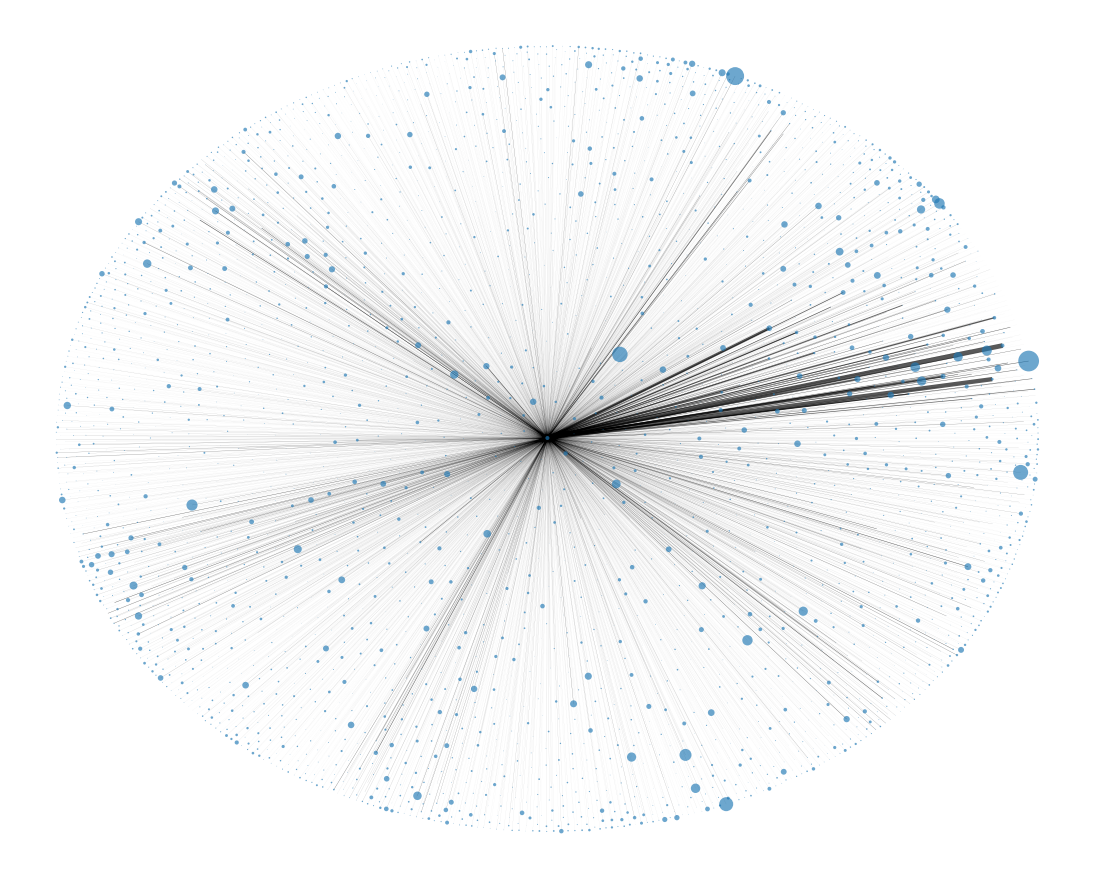

In [292]:
plt.figure(figsize=(15, 12))
pos = nx.kamada_kawai_layout(g_sf)
nx.draw(g_sf,
        pos,
        nodelist=node_attributes_sf.keys(), 
        node_size=[v for v in node_attributes_sf.values()], 
        with_labels=False, 
        font_size=10, 
        width= [data['scaled_sci']/50000 for node1, node2, data in g_sf.edges(data=True)], 
        linewidths=0,
        alpha=0.65)

plt.show()

## Intro - Kern County, network

In [293]:
kern_county = fb[fb['user_loc'] == '06029']

In [294]:
g_kern = nx.from_pandas_edgelist(kern_county, "user_loc", "fr_loc", ["scaled_sci", "log_sci"])
print('# of edges: {}'.format(g_kern.number_of_edges()))
print('# of nodes: {}'.format(g_kern.number_of_nodes()))

# of edges: 3229
# of nodes: 3229


In [295]:
# reset index of na_fips_pop_covid
# na_fips_pop_covid = na_fips_pop_covid.reset_index()

# create nodelist from popdensci_join
nodelist = na_fips_pop_covid.copy()
nodelist = nodelist[['FIPS', 'cases_per_capita']]

In [296]:
# convert node attributes in nodelist to dict
node_attributes_kern = dict(zip(nodelist.FIPS, nodelist.cases_per_capita))

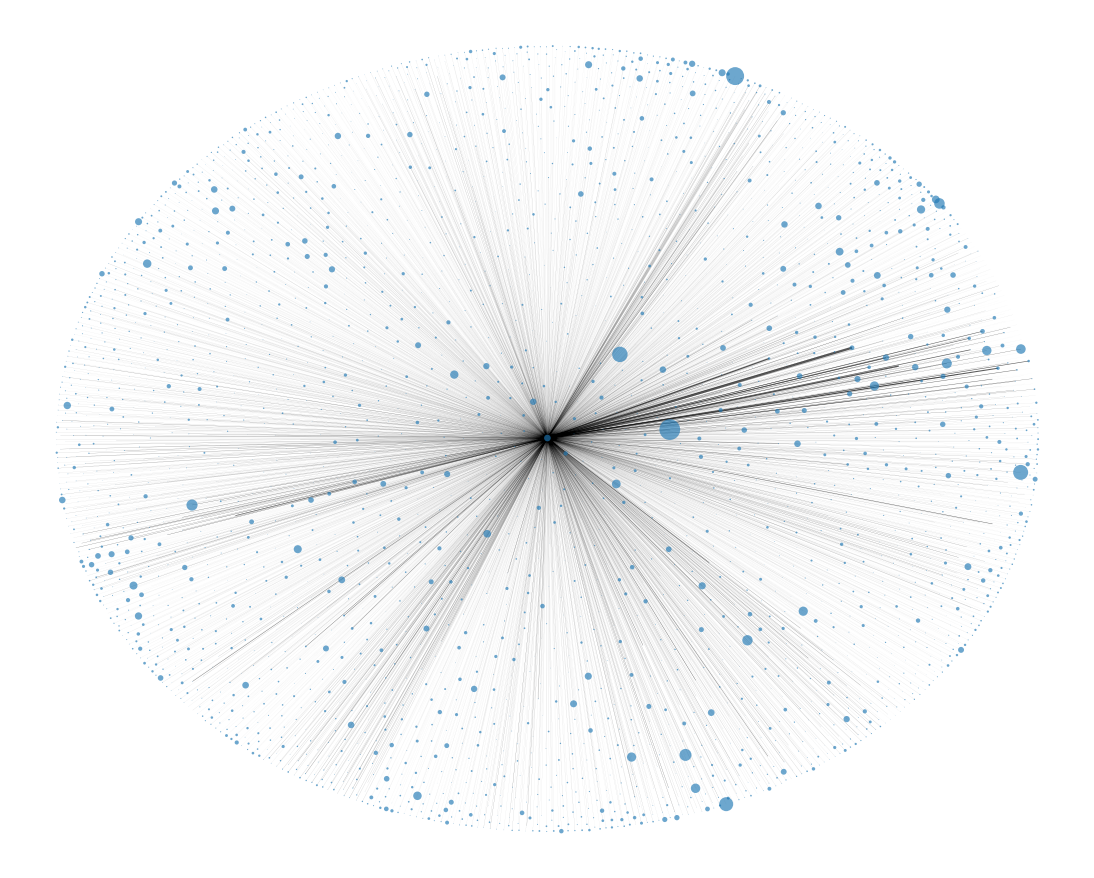

In [298]:
plt.figure(figsize=(15, 12))
pos = nx.kamada_kawai_layout(g_kern)
nx.draw(g_kern,
        pos,
        nodelist=node_attributes_kern.keys(), 
        node_size=[v for v in node_attributes_kern.values()], 
        with_labels=False, 
        font_size=10, 
        width= [data['scaled_sci']/50000 for node1, node2, data in g_kern.edges(data=True)], 
        linewidths=0,
        alpha=0.65)

plt.show()

## SCI Quantile Exploration

### Lower 25%

In [ ]:
lower_25_edges_sample = fb_ga_lower_25.sample(n=2000)

In [ ]:
lower_25_edges_sample.drop(labels=['SCI_lower_25', 'SCI_upper_25', 'SCI_middle_50'], axis=1, inplace=True)

In [ ]:
lower_25_edges_sample

In [ ]:
g_lower_25_sample = nx.from_pandas_edgelist(lower_25_edges_sample, "user_loc", "fr_loc", ["scaled_sci", "log_sci"])
print('# of edges: {}'.format(g_lower_25_sample.number_of_edges()))
print('# of nodes: {}'.format(g_lower_25_sample.number_of_nodes()))

In [ ]:
na_fips_pop_covid

In [ ]:
# reset index of na_fips_pop_covid
# na_fips_pop_covid = na_fips_pop_covid.reset_index()

# create nodelist from popdensci_join
node_attributes_lower_25_sample = na_fips_pop_covid.copy()
node_attributes_lower_25_sample = node_attributes_lower_25_sample[['FIPS', 'cases']]

In [ ]:
# deduplicate nodelists by joining edgelist to it
node_attributes_lower_25_sample = lower_25_edges_sample.set_index('user_loc').join(node_attributes_lower_25_sample.set_index('FIPS'))

In [ ]:
# convert node attributes in nodelist to dict
node_attributes_lower_25_sample = dict(zip(node_attributes_lower_25_sample.fr_loc, node_attributes_lower_25_sample.cases))

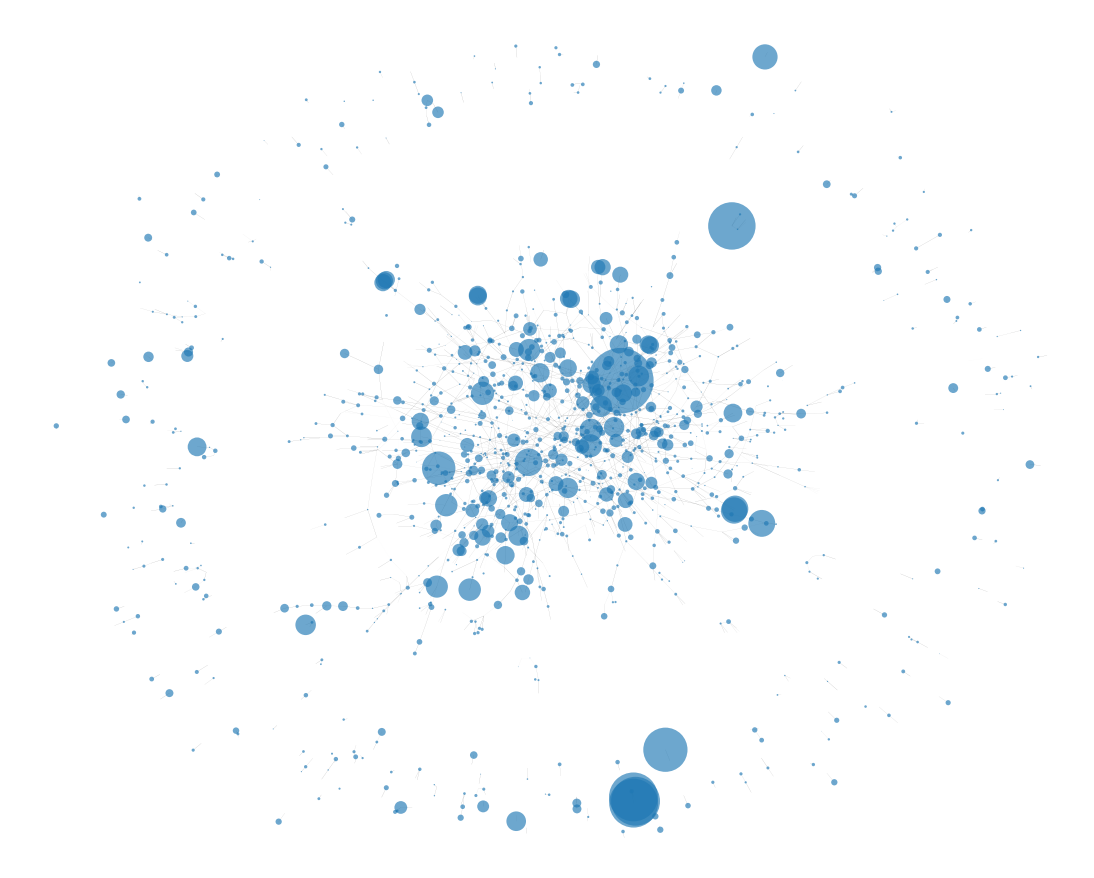

In [308]:
plt.figure(figsize=(15, 12))
# pos = nx.kamada_kawai_layout(g)
nx.draw(g_lower_25_sample,
        nodelist=node_attributes_lower_25_sample.keys(), 
        node_size=[v/100 for v in node_attributes_lower_25_sample.values()], 
        with_labels=False, 
        font_size=10, 
        width= [data['scaled_sci']/10000 for node1, node2, data in g_lower_25_sample.edges(data=True)], 
        linewidths=0,
        alpha=0.65)

plt.show()

### Middle 50%

In [ ]:
middle_50_sample

In [ ]:
middle_50_edges_sample = fb_ga_middle_50.sample(n=2000)

In [ ]:
middle_50_edges_sample.drop(labels=['SCI_lower_25', 'SCI_upper_25', 'SCI_middle_50'], axis=1, inplace=True)

In [ ]:
middle_50_edges_sample

In [ ]:
g_middle_50_sample = nx.from_pandas_edgelist(middle_50_edges_sample, "user_loc", "fr_loc", ["scaled_sci", "log_sci"])
print('# of edges: {}'.format(g_middle_50_sample.number_of_edges()))
print('# of nodes: {}'.format(g_middle_50_sample.number_of_nodes()))

In [177]:
na_fips_pop_covid

FIPS State          Area_Name 2010_pop        date      county  \
0     01001    AL     Autauga County   54,571  2020-12-04     Autauga   
1     01003    AL     Baldwin County  182,265  2020-12-04     Baldwin   
2     01005    AL     Barbour County   27,457  2020-12-04     Barbour   
3     01007    AL        Bibb County   22,915  2020-12-04        Bibb   
4     01009    AL      Blount County   57,322  2020-12-04      Blount   
...     ...   ...                ...      ...         ...         ...   
3129  56037    WY  Sweetwater County   43,806  2020-12-04  Sweetwater   
3130  56039    WY       Teton County   21,294  2020-12-04       Teton   
3131  56041    WY       Uinta County   21,118  2020-12-04       Uinta   
3132  56043    WY    Washakie County    8,533  2020-12-04    Washakie   
3133  56045    WY      Weston County    7,208  2020-12-04      Weston   

        state   cases  deaths  cases_per_capita  
0     Alabama  2945.0    42.0             2.945  
1     Alabama  9501.0   138.0             9.501  
2     Alabama  1217.0    29.0             1.217  
3     Alabama  1270.0    38.0             1.270  
4     Alabama  3231.0    46.0             3.231  
...       ...     ...     ...               ...  
3129  Wyoming  2077.0    10.0             2.077  
3130  Wyoming  1724.0     2.0             1.724  
3131  Wyoming  1175.0     5.0             1.175  
3132  Wyoming   517.0     8.0             0.517  
3133  Wyoming   419.0     2.0             0.419  

[3134 rows x 10 columns]

In [217]:
# reset index of na_fips_pop_covid
# na_fips_pop_covid = na_fips_pop_covid.reset_index()

# create nodelist from popdensci_join
node_attributes_middle_50_sample = na_fips_pop_covid.copy()
node_attributes_middle_50_sample = node_attributes_middle_50_sample[['FIPS', 'cases']]

In [218]:
# deduplicate nodelists by joining edgelist to it
node_attributes_middle_50_sample = middle_50_edges_sample.set_index('user_loc').join(node_attributes_middle_50_sample.set_index('FIPS'))

In [219]:
# convert node attributes in nodelist to dict
node_attributes_middle_50_sample = dict(zip(node_attributes_middle_50_sample.fr_loc, node_attributes_middle_50_sample.cases))

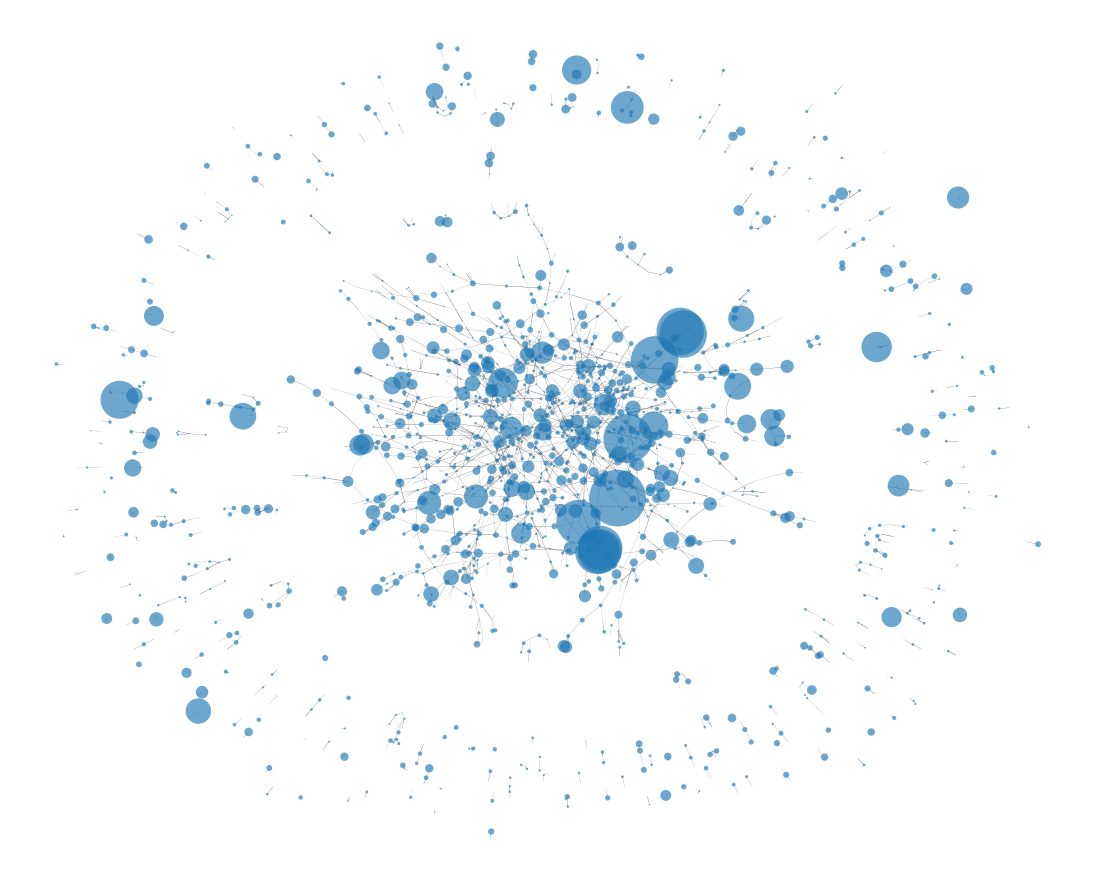

In [220]:
plt.figure(figsize=(15, 12))
# pos = nx.kamada_kawai_layout(g)
nx.draw(g_middle_50_sample,
        nodelist=node_attributes_middle_50_sample.keys(), 
        node_size=[v/100 for v in node_attributes_middle_50_sample.values()], 
        with_labels=False, 
        font_size=10, 
        width= [data['scaled_sci']/10000 for node1, node2, data in g_middle_50_sample.edges(data=True)], 
        linewidths=0,
        alpha=0.65)

plt.show()

### Upper 25%

In [299]:
upper_25_edges_sample = fb_ga_upper_25.sample(n=2000)

In [300]:
upper_25_edges_sample.drop(labels=['SCI_lower_25', 'SCI_upper_25', 'SCI_middle_50'], axis=1, inplace=True)

In [301]:
upper_25_edges_sample

user_loc fr_loc  scaled_sci   log_sci
6522421    38061  55049       15999  4.204093
7909625    47045  35019        4391  3.642563
1742370    13309  37101        4588  3.661623
9152867    51031  36109        4816  3.682686
245971     02105  16035       28485  4.454616
...          ...    ...         ...       ...
2952913    20055  30021        5758  3.760272
6120921    37013  37155       35109  4.545418
1158078    12079  39109        9473  3.976488
8503461    48223  29045        5638  3.751125
8133960    47185  04025        5952  3.774663

[2000 rows x 4 columns]

In [302]:
g_upper_25_sample = nx.from_pandas_edgelist(upper_25_edges_sample, "user_loc", "fr_loc", ["scaled_sci", "log_sci"])
print('# of edges: {}'.format(g_upper_25_sample.number_of_edges()))
print('# of nodes: {}'.format(g_upper_25_sample.number_of_nodes()))

# of edges: 2000
# of nodes: 2224


In [303]:
na_fips_pop_covid

index   FIPS State          Area_Name 2010_pop        date      county  \
0         0  01001    AL     Autauga County   54,571  2020-12-04     Autauga   
1         1  01003    AL     Baldwin County  182,265  2020-12-04     Baldwin   
2         2  01005    AL     Barbour County   27,457  2020-12-04     Barbour   
3         3  01007    AL        Bibb County   22,915  2020-12-04        Bibb   
4         4  01009    AL      Blount County   57,322  2020-12-04      Blount   
...     ...    ...   ...                ...      ...         ...         ...   
3129   3129  56037    WY  Sweetwater County   43,806  2020-12-04  Sweetwater   
3130   3130  56039    WY       Teton County   21,294  2020-12-04       Teton   
3131   3131  56041    WY       Uinta County   21,118  2020-12-04       Uinta   
3132   3132  56043    WY    Washakie County    8,533  2020-12-04    Washakie   
3133   3133  56045    WY      Weston County    7,208  2020-12-04      Weston   

        state   cases  deaths  cases_per_capita  
0     Alabama  2945.0    42.0             2.945  
1     Alabama  9501.0   138.0             9.501  
2     Alabama  1217.0    29.0             1.217  
3     Alabama  1270.0    38.0             1.270  
4     Alabama  3231.0    46.0             3.231  
...       ...     ...     ...               ...  
3129  Wyoming  2077.0    10.0             2.077  
3130  Wyoming  1724.0     2.0             1.724  
3131  Wyoming  1175.0     5.0             1.175  
3132  Wyoming   517.0     8.0             0.517  
3133  Wyoming   419.0     2.0             0.419  

[3134 rows x 11 columns]

In [304]:
# reset index of na_fips_pop_covid
# na_fips_pop_covid = na_fips_pop_covid.reset_index()

# create nodelist from popdensci_join
node_attributes_upper_25_sample = na_fips_pop_covid.copy()
node_attributes_upper_25_sample = node_attributes_upper_25_sample[['FIPS', 'cases']]

In [305]:
# deduplicate nodelists by joining edgelist to it
node_attributes_upper_25_sample = upper_25_edges_sample.set_index('user_loc').join(node_attributes_upper_25_sample.set_index('FIPS'))

In [306]:
# convert node attributes in nodelist to dict
node_attributes_upper_25_sample = dict(zip(node_attributes_upper_25_sample.fr_loc, node_attributes_upper_25_sample.cases))

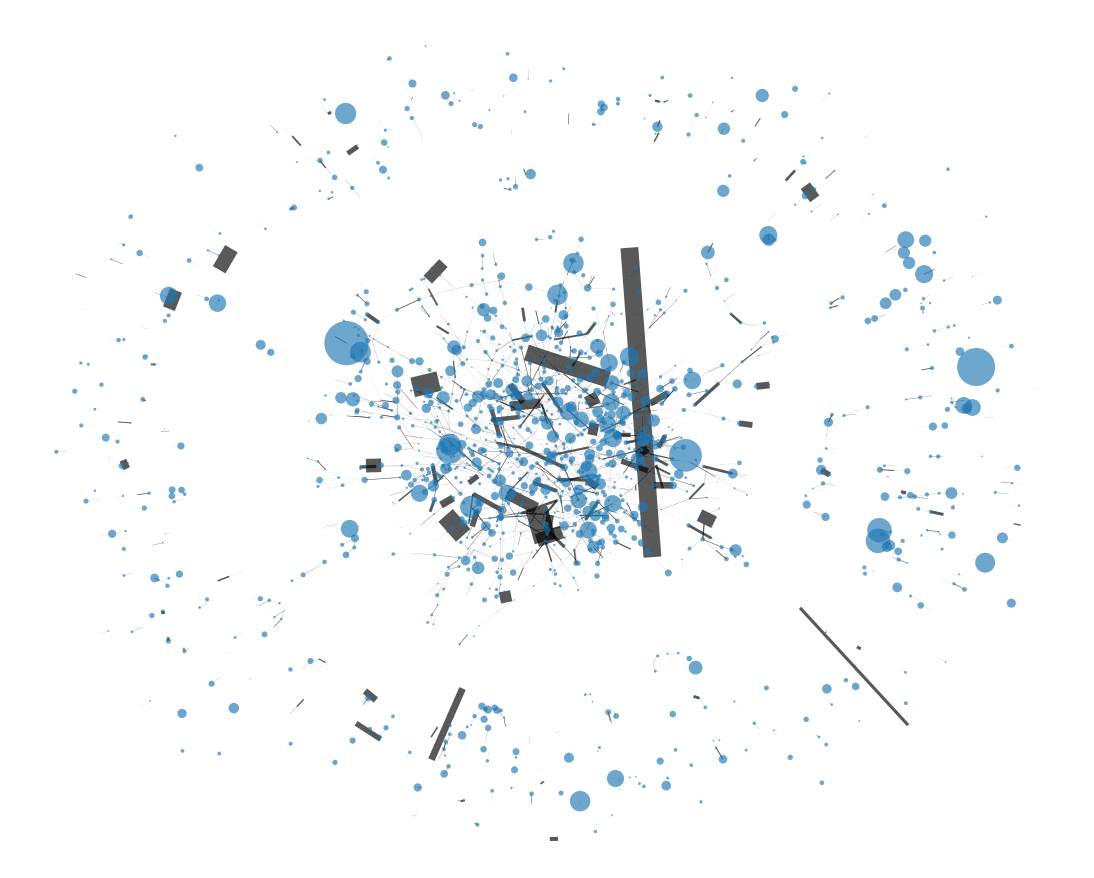

In [307]:
plt.figure(figsize=(15, 12))
# pos = nx.kamada_kawai_layout(g)
nx.draw(g_upper_25_sample,
        nodelist=node_attributes_upper_25_sample.keys(), 
        node_size=[v/100 for v in node_attributes_upper_25_sample.values()], 
        with_labels=False, 
        font_size=10, 
        width= [data['scaled_sci']/100000 for node1, node2, data in g_upper_25_sample.edges(data=True)], 
        linewidths=0,
        alpha=0.65)

plt.show()

## Hypothesis Testing

After taking a sample of upper SCI quartile counties, is the average number of COVID cases per capita significantly greater than the population mean?

1. Formulate hypotheses

$H_0$: High SCI counties have fewer or equal COVID cases per capita than the population average of 4.45 cases/capita.

$H_a$: High SCI counties have more average COVID cases per capita than the average of 4.45 cases/capita.

2. Choose a significance level

$\alpha = 0.05$ 

3. Choose a statistical test, find the test statistic

- z test

- $\bar{X}$ = 

4. Compute probability of results assuming the null hypothesis is true

- outputs the p value

5. Compare p-value to alpha to draw conclusion

- p <= alpha, reject null in favor of the alternative
- p > alpha, fail to reject the null


3a. calculate sample mean from size n, calculate sample standard deviation

3b. calculate z statistic - 
sample mean - population mean / (pop standard deviation / sqroot of n)



In [422]:
# container of upper quartile SCI counties
ht_ga_upper_25 = fb_ga_upper_25.drop_duplicates('user_loc')

# container of sample of upper quartile SCI counties
ht_ga_upper_25_sample = ht_ga_upper_25.sample(n=300)

# container of sample upper quartile SCI counties + COVID/capita
ht_ga_upper_25_sample = ht_ga_upper_25_sample.set_index('user_loc').join(na_fips_pop_covid.set_index('FIPS'))

In [423]:
# population mean COVID cases/capita
pop_mean = na_fips_pop_covid['cases_per_capita'].mean()
print(f"Population mean: {na_fips_pop_covid['cases_per_capita'].mean():.2f}")

# population standard deviation COVID cases/capita
pop_std = na_fips_pop_covid['cases_per_capita'].std()
print(f"Population standard deviation: {na_fips_pop_covid['cases_per_capita'].std():.2f}")

# sample mean of COVID cases/capita
sample_mean = ht_ga_upper_25_sample['cases_per_capita'].mean()
print(f"Sample mean: {ht_ga_upper_25_sample['cases_per_capita'].mean():.2f}")

# sample standard deviation
sample_std = ht_ga_upper_25_sample['cases_per_capita'].std()
print(f"Sample standard deviation: {ht_ga_upper_25_sample['cases_per_capita'].std():.2f}")

# z score
z_score = sample_mean-pop_mean/(pop_std/np.sqrt(300))
print(f"z score: {sample_mean-po  p_mean/(pop_std/np.sqrt(300)):.2f}")

# p value
import scipy.stats as st
print(f"p-value: {st.norm.pdf(z_score):.2f}")

Population mean: 4.45
Population standard deviation: 15.09
Sample mean: 3.48
Sample standard deviation: 9.21
z score: -1.64
p-value: 0.10


In [337]:
na_fips_pop_covid

index   FIPS State          Area_Name 2010_pop        date      county  \
0         0  01001    AL     Autauga County   54,571  2020-12-04     Autauga   
1         1  01003    AL     Baldwin County  182,265  2020-12-04     Baldwin   
2         2  01005    AL     Barbour County   27,457  2020-12-04     Barbour   
3         3  01007    AL        Bibb County   22,915  2020-12-04        Bibb   
4         4  01009    AL      Blount County   57,322  2020-12-04      Blount   
...     ...    ...   ...                ...      ...         ...         ...   
3129   3129  56037    WY  Sweetwater County   43,806  2020-12-04  Sweetwater   
3130   3130  56039    WY       Teton County   21,294  2020-12-04       Teton   
3131   3131  56041    WY       Uinta County   21,118  2020-12-04       Uinta   
3132   3132  56043    WY    Washakie County    8,533  2020-12-04    Washakie   
3133   3133  56045    WY      Weston County    7,208  2020-12-04      Weston   

        state   cases  deaths  cases_per_capita  
0     Alabama  2945.0    42.0             2.945  
1     Alabama  9501.0   138.0             9.501  
2     Alabama  1217.0    29.0             1.217  
3     Alabama  1270.0    38.0             1.270  
4     Alabama  3231.0    46.0             3.231  
...       ...     ...     ...               ...  
3129  Wyoming  2077.0    10.0             2.077  
3130  Wyoming  1724.0     2.0             1.724  
3131  Wyoming  1175.0     5.0             1.175  
3132  Wyoming   517.0     8.0             0.517  
3133  Wyoming   419.0     2.0             0.419  

[3134 rows x 11 columns]

___________________________________________________________________________________________________________________

In [1477]:
plotlist = fb.sample(n=2000)

In [1478]:
# import edge list from pandas dataframe plotlist
g = nx.from_pandas_edgelist(plotlist, "user_loc", "fr_loc", ["scaled_sci", "log_sci"])
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 2000
# of nodes: 2291


In [1482]:
# reset index of na_fips_pop_covid
# na_fips_pop_covid = na_fips_pop_covid.reset_index()

# create nodelist from popdensci_join
nodelist = na_fips_pop_covid.copy()
nodelist = nodelist[['FIPS', 'cases_per_capita']]

In [1483]:
# deduplicate nodelists by joining edgelist to it
nodelist = plotlist.set_index('user_loc').join(nodelist.set_index('FIPS'))

In [1484]:
# convert node attributes in nodelist to dict
node_attributes = dict(zip(nodelist.fr_loc, nodelist.cases_per_capita))

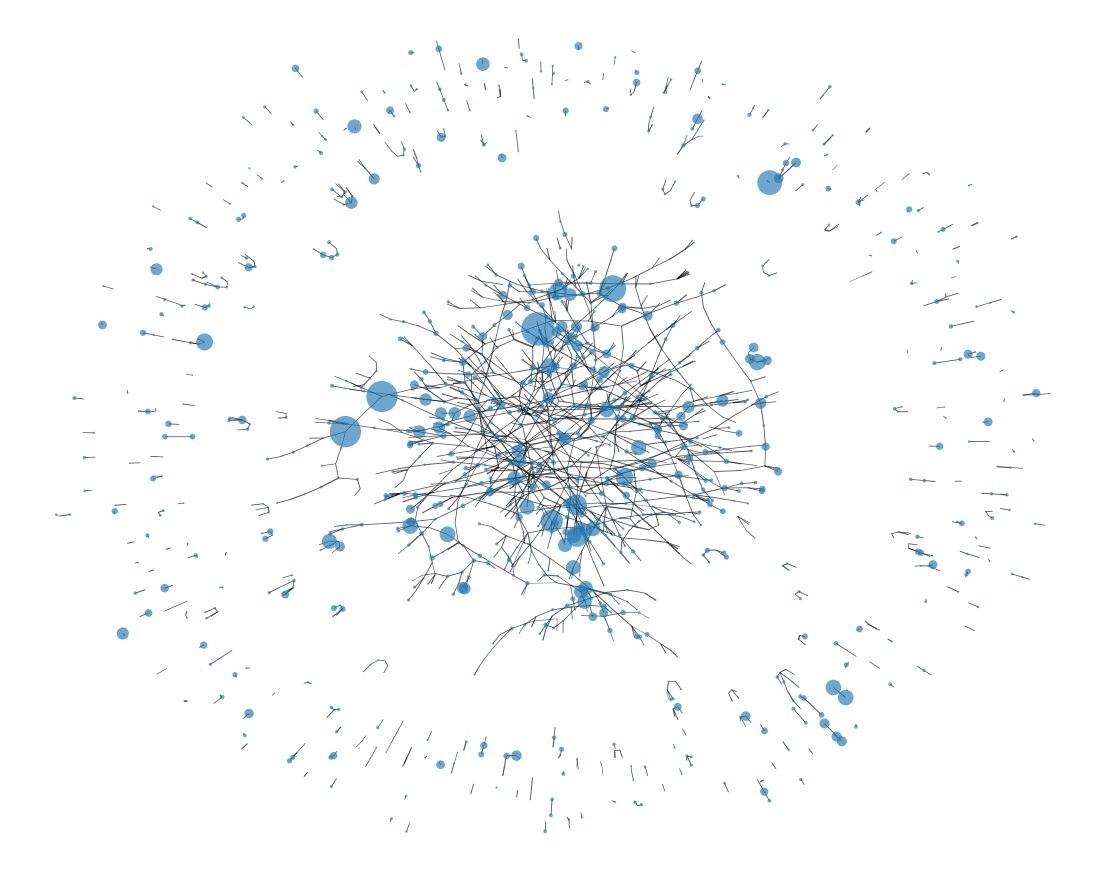

In [1491]:
plt.figure(figsize=(15, 12))
# pos = nx.kamada_kawai_layout(g)
nx.draw(g,
        nodelist=node_attributes.keys(), 
        node_size=[v*5 for v in node_attributes.values()], 
        with_labels=False, 
        font_size=10, 
        width= [data['log_sci']/4 for node1, node2, data in g.edges(data=True)], 
        linewidths=0,
        alpha=0.65)

plt.show()

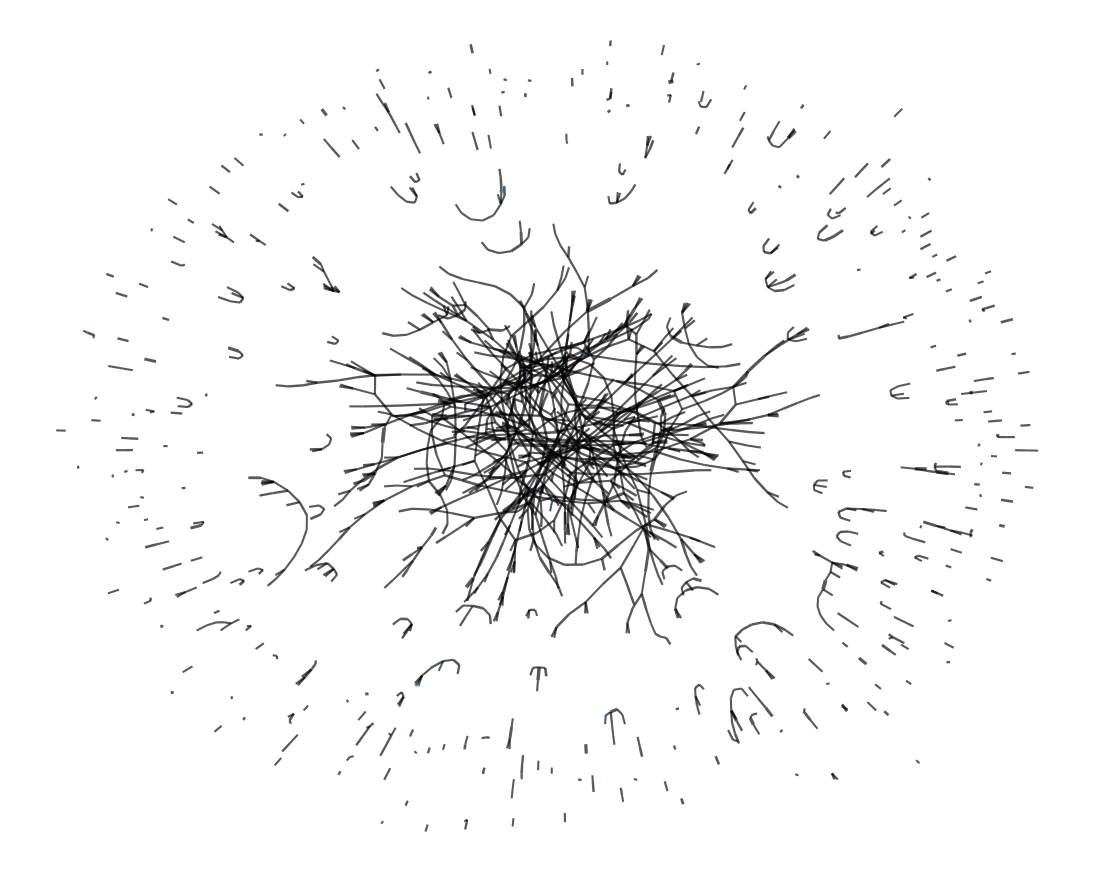

In [1468]:
plt.figure(figsize=(15, 12))
# pos = nx.kamada_kawai_layout(g)
nx.draw(g,
        nodelist=node_attributes.keys(), 
        node_size=[v/15 for v in node_attributes.values()], 
        with_labels=False, 
        font_size=10, 
        width= [data['log_sci']/2 for node1, node2, data in g.edges(data=True) if data['log_sci'] > 4], 
        linewidths=0,
        alpha=0.65)

plt.show()

____________________________________________________________

In [ ]:
print('# of edges: {}'.format(G.number_of_edges()))
print('# of nodes: {}'.format(G.number_of_nodes()))

In [904]:
import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [890]:



edgelist = fb.copy().drop(columns='scaled_sci')

zips  cases_per_zip  cases_per_capita
0     36067    2275.724033         54.183906
1     36003     166.749090          3.970216
2     36091     308.000344          7.333342
3     36051     194.526533          4.631584
4     36017     187.413255          6.462526
...     ...            ...               ...
2231  53045    6120.043470         26.266281
2232  53007     519.551786          2.229836
2233  53017    1562.888533          6.707676
2234  53029    5869.721669         25.191938
2235  53069     196.701572          0.844213

[2236 rows x 3 columns]

In [957]:
plotlist = edgelist.sample(n=2000)

g = nx.Graph()

for i, elrow in plotlist.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())


In [992]:
plotlist

user_loc fr_loc   log_sci
5634031    31183  48267  0.000000
176112     01109  32001  3.291147
9679259    54013  37115  3.562174
3188184    20201  22099  2.816904
6619374    39015  72011  1.662758
...          ...    ...       ...
1857071    16051  13019  3.123198
3189318    20201  42105  3.375664
9781826    54077  23019  3.198382
6314464    37133  33013  3.925518
6529534    38067  13223  2.910091

[2000 rows x 3 columns]

In [964]:
print(elrow[0]) # node1
print(elrow[1]) # node2
print(elrow[2:].to_dict()) # edge attribute dict


38067
13223
{'log_sci': 2.910090545594068}


In [965]:
# add node attributes
for i, nlrow in nodelist.iterrows():
    try:
        g.nodes[nlrow['zips']].update(nlrow[1:].to_dict())
    except KeyError:
        continue

In [966]:
# add edges and edge attributes
for i, elrow in plotlist.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [967]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

%time

# of edges: 2001
# of nodes: 2272
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [968]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 2001
# of nodes: 2272


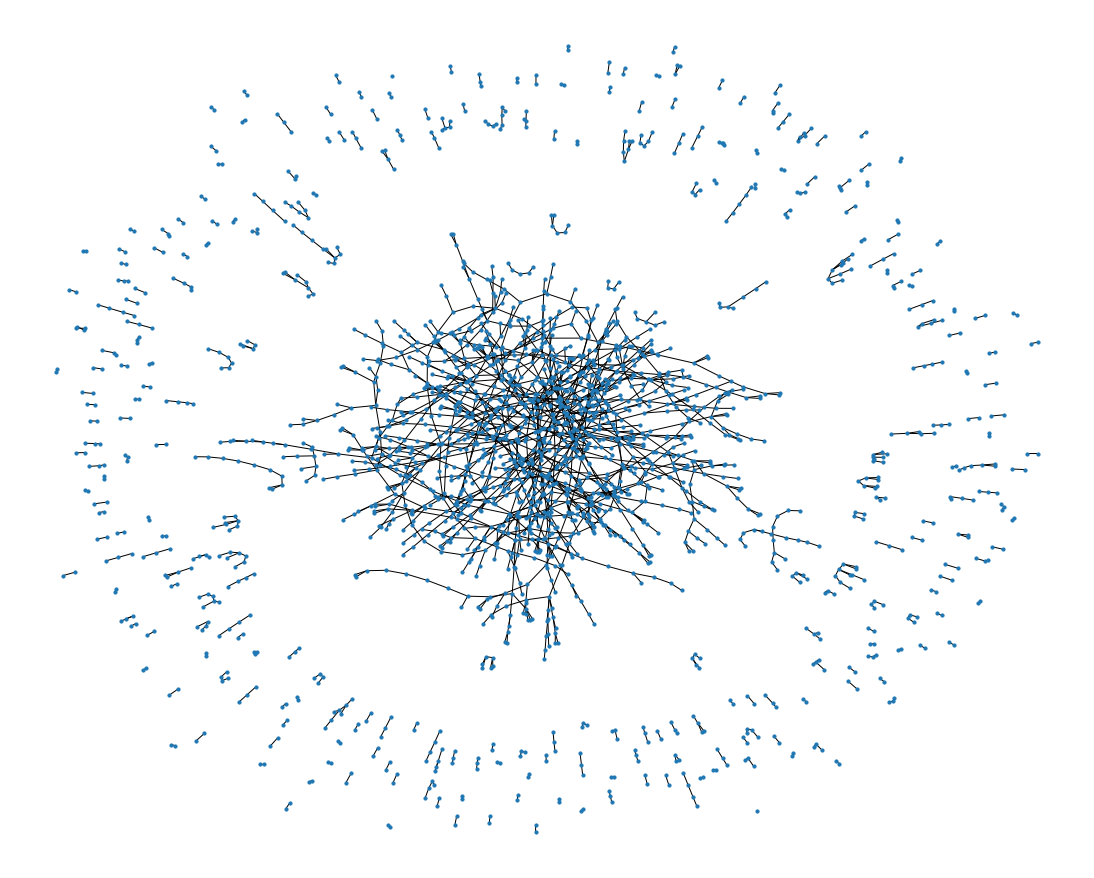

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 4.05 µs


In [969]:
plt.figure(figsize=(15, 12))
nx.draw(g, node_size=10)
plt.show()

%time

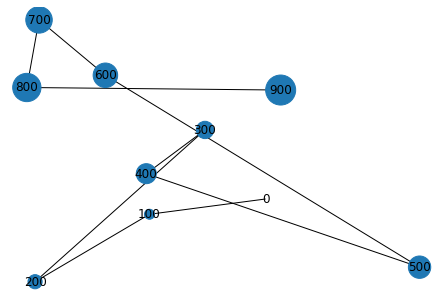

In [935]:
import sys, networkx as nx, matplotlib.pyplot as plt

# Create a list of 10 nodes numbered [0, 9]
nodes = range(10)
node_sizes = []
labels = {}
for n in nodes:
        node_sizes.append( 100 * n )
        labels[n] = 100 * n

# Node sizes: [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

# Connect each node to its successor
edges = [ (i, i+1) for i in range(len(nodes)-1) ]

# Create the graph and draw it with the node labels
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

nx.draw_random(g, node_size = node_sizes, labels=labels, with_labels=True)    
plt.show()

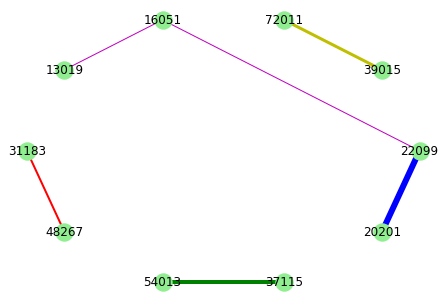

In [996]:
G = nx.Graph()
G.add_edge('31183','48267',color='r',weight=2)
G.add_edge('54013','37115',color='g',weight=4)
G.add_edge('20201','22099',color='b',weight=6)
G.add_edge('39015','72011',color='y',weight=3)
G.add_edge('16051','13019',color='m',weight=1)
G.add_edge('16051','22099',color='m',weight=1)

colors = nx.get_edge_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()

pos = nx.shell_layout(G)
nx.draw(G, pos,
        edge_color=colors,
        width=list(weights),
        with_labels=True,
        node_color='lightgreen')

In [ ]:
import networkx as nx

G = nx.Graph()
G.add_edge(1,2,color='r',weight=2)
G.add_edge(2,3,color='b',weight=4)
G.add_edge(3,4,color='g',weight=6)

pos = nx.circular_layout(G)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)